In [1]:
import os

# Set Kaggle API key and username
os.environ['KAGGLE_USERNAME'] = 'KAGGLE_USERNAME'
os.environ['KAGGLE_KEY'] = 'KAGGLE_KEY'

In [2]:
!kaggle datasets download -d emmarex/plantdisease


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
from zipfile import ZipFile
file_name = "/content/plantdisease.zip" # Changed the file name to the correct one.
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [4]:
import os
import shutil

# Set the path to the dataset directory
dataset_dir = "/content/PlantVillage"

# List all directories in the dataset
directories = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]

# Specify the directories you want to delete (all paths should be relative to dataset_dir)
directories_to_delete = [
    "Pepper__bell___Bacterial_spot",
    "Pepper__bell___healthy",
    "Potato___Early_blight",
    "Potato___healthy",
    "Potato___Late_blight",
]

# Iterate over the directories and delete them along with their contents
for directory in directories_to_delete:
    directory_path = os.path.join(dataset_dir, directory)
    if os.path.exists(directory_path):
        shutil.rmtree(directory_path)
        print(f"Deleted directory: {directory_path}")
    else:
        print(f"Directory not found: {directory_path}")


Deleted directory: /content/PlantVillage/Pepper__bell___Bacterial_spot
Deleted directory: /content/PlantVillage/Pepper__bell___healthy
Deleted directory: /content/PlantVillage/Potato___Early_blight
Deleted directory: /content/PlantVillage/Potato___healthy
Deleted directory: /content/PlantVillage/Potato___Late_blight


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Use tensorflow.keras instead of just keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout, MaxPooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers
from tensorflow.keras.applications.vgg16 import preprocess_input # Use tensorflow.keras instead of just keras
from tensorflow.keras.preprocessing import image # Use tensorflow.keras instead of just keras
# from keras.preprocessing.image import ImageDataGenerator # No longer needed
from tensorflow.keras.models import Sequential # Use tensorflow.keras instead of just keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import os
import cv2
from tensorflow.keras.utils import load_img, img_to_array # Use tensorflow.keras instead of just keras
import tensorflow as tf


**Directories & Classes**<br>
These are the path of the dataset innter folders and classes in the given dataset

In [6]:
DIRECTORY = r'/content/'
FOLDERS = ['PlantVillage']
CLASSES = ['Tomato_healthy',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Leaf_Mold',
 'Tomato_Bacterial_spot',
 'Tomato_Late_blight',
 'Tomato_Early_blight',
 'Tomato__Tomato_YellowLeaf__Curl_Virus']


**Load Data**<br>
The given code is loading the training and validation data from the dataset and convert these images to array with the size of 256x256 and append each image datain train_data, and val_data list. I have loaded just 2500 images from eaach class due to limitted resources.


In [7]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS =20

In [8]:
data = []
for folder in FOLDERS:
  folder_path = os.path.join(DIRECTORY, folder)
  for classification in CLASSES:
    image_path = os.path.join(folder_path, classification)
    images = os.listdir(image_path)
    images = images[:500]
    for image in images:
      try:
        image_url = os.path.join(image_path, image)
        arr = cv2.imread(image_url)
        arr = cv2.resize(arr, (IMAGE_SIZE,IMAGE_SIZE))
        label = CLASSES.index(classification)
        data.append([arr, label])
      except Exception as e:
        print("Error : ",e)

In [9]:
len(data)

4873

In [10]:
classes_names = CLASSES
print(classes_names)

['Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato_Septoria_leaf_spot', 'Tomato__Tomato_mosaic_virus', 'Tomato_Leaf_Mold', 'Tomato_Bacterial_spot', 'Tomato_Late_blight', 'Tomato_Early_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


In [11]:
import random
random.shuffle(data)


**Seperate Dependent & Independent Data**

In [12]:
X = []
y = []
for feature, label in data:
  X.append(feature)
  y.append(label)


In [13]:


X = np.array(X)
y = np.array(y)


In [14]:
X.shape

(4873, 224, 224, 3)

In [15]:
y.shape

(4873,)

**Function to Split Dataset**
Dataset should be bifurcated into 3 subsets, namely:<br>

**Training:** Dataset to be used while training<br>

**Test**: Dataset to be tested against after we trained a mo

In [16]:

from sklearn.model_selection import train_test_split

# Assuming you have your data stored in X and corresponding labels in y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [17]:
len(X_train)

4385

In [18]:
len(y_train)

4385

In [19]:

len(X_test)

488

In [20]:
len(y_test)

488

In [21]:
print(y_train.shape)  # Check shape of y_train
print(X_train.shape)  # Check shape of X_train



(4385,)
(4385, 224, 224, 3)


**Building the Model**<br>
**Creating a Layer for Resizing and Normalization**<br>
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.<br>

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it


**Data Augmentation**<br>
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [22]:
# Assume X_train has shape (4384, 224, 224, 3) and y_train has shape (4384, 10)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Print the shapes to verify
print(f"Training data shape: {X_train_split.shape}, {y_train_split.shape}")
print(f"Validation data shape: {X_val_split.shape}, {y_val_split.shape}")


Training data shape: (3508, 224, 224, 3), (3508,)
Validation data shape: (877, 224, 224, 3), (877,)


In [23]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,           # Normalize pixel values to [0, 1]
    rotation_range=20,            # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,        # Randomly shift images horizontally by 20%
    height_shift_range=0.2,       # Randomly shift images vertically by 20%
    shear_range=0.2,              # Shear transformation
    zoom_range=0.2,                 # Random zoom
    horizontal_flip=True,         # Flip images horizontally
)

# For validation, we don't apply augmentation, only rescaling (if needed)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


In [24]:
from tensorflow.keras.utils import to_categorical
# Convert labels to one-hot encoding
y_train_split = to_categorical(y_train_split, num_classes=10)
y_val_split = to_categorical(y_val_split, num_classes=10)

In [25]:
# Training generator
train_generator = train_datagen.flow(
    x=X_train_split,
    y=y_train_split,
    batch_size=32
)

# Validation generator
val_generator = val_datagen.flow(
    x=X_val_split,
    y=y_val_split,
    batch_size=32
)


In [26]:
print(f"Number of training samples: {train_generator.n}")
print(f"Number of validation samples: {val_generator.n}")

Number of training samples: 3508
Number of validation samples: 877


**inception v3**

In [27]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical



# Define the model creation function
def create_model(base_model):
    base_model.trainable = False  # Freeze the base model layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(10, activation='softmax')(x)  # 10 classes for classification
    model = Model(inputs=base_model.input, outputs=output_layer)
    return model

# Initialize InceptionV3 as the base model (without top layers)
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_model = create_model(inception_base)

inception_base.trainable = True

# Compile the model
inception_model.compile(optimizer=tf.keras.optimizers.Adam(),
                        loss=tf.keras.losses.CategoricalCrossentropy(),
                        metrics=[tf.keras.metrics.CategoricalAccuracy()])

# Train the model
print("\nTraining InceptionV3 Model")
inception_history = inception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)




87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training InceptionV3 Model
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 190s 943ms/step - categorical_accuracy: 0.4830 - loss: 1.5900 - val_categorical_accuracy: 0.1414 - val_loss: 3.5881
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 97s 446ms/step - categorical_accuracy: 0.7848 - loss: 0.7557 - val_categorical_accuracy: 0.2372 - val_loss: 12.3757
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 51s 432ms/step - categorical_accuracy: 0.8335 - loss: 0.5667 - val_categorical_accuracy: 0.6568 - val_loss: 1.4358
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 51s 448ms/step - categorical_accuracy: 0.8786 - loss: 0.4593 - val_categorical_accuracy: 0.7548 - val_loss: 0.8818
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 81s 437ms/step - categorical_accuracy: 0.8652 - loss: 0.4904 - val_categorical_accuracy: 0.7001 - val_loss: 2.5857
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 51s 436ms/step - categorical_accuracy: 0.8799 - loss: 0.4280 - val_categorical_accuracy: 0.7697 - val_loss: 0.9098
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 50s 438ms/step - categorical_accuracy: 

In [28]:
# Assuming y_test_raw contains class indices
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Verify the shape
print("y_test shape after one-hot encoding:", y_test.shape)


y_test shape after one-hot encoding: (488, 10)


In [29]:
test_loss, test_accuracy = inception_model.evaluate(X_test, y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 388ms/step - categorical_accuracy: 0.0773 - loss: 14.3094


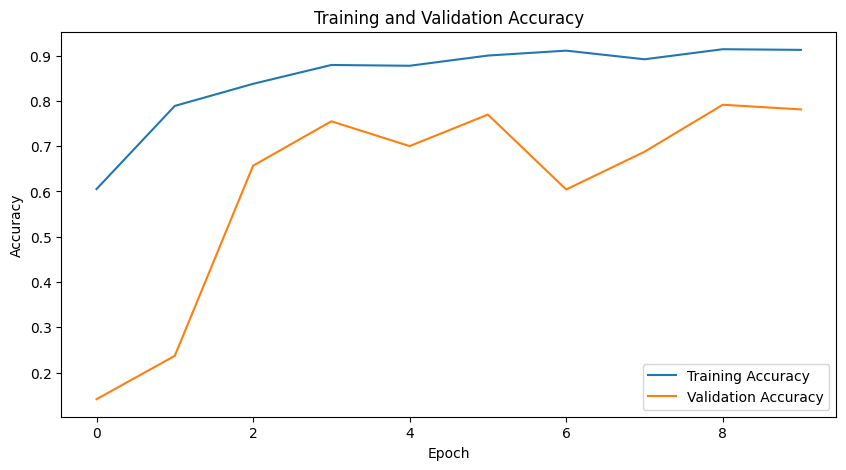

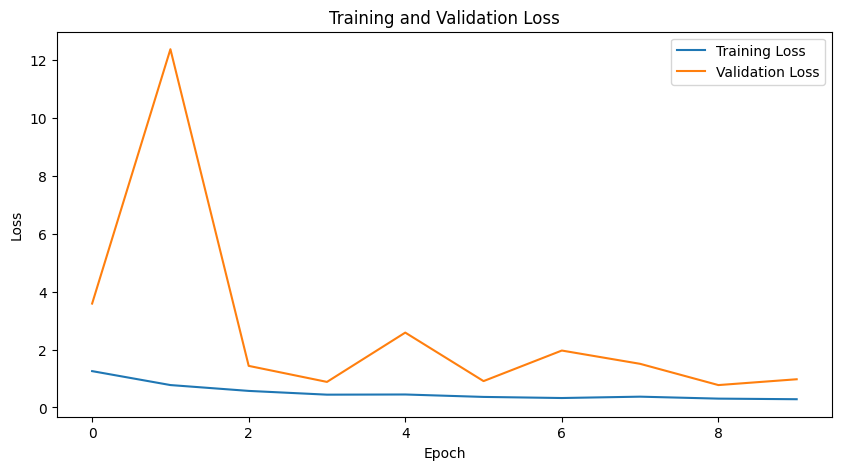

In [30]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(inception_history.history['categorical_accuracy'], label='Training Accuracy') # Changed 'accuracy' to 'categorical_accuracy'
plt.plot(inception_history.history['val_categorical_accuracy'], label='Validation Accuracy') # Changed 'val_accuracy' to 'val_categorical_accuracy'
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(inception_history.history['loss'], label='Training Loss')
plt.plot(inception_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


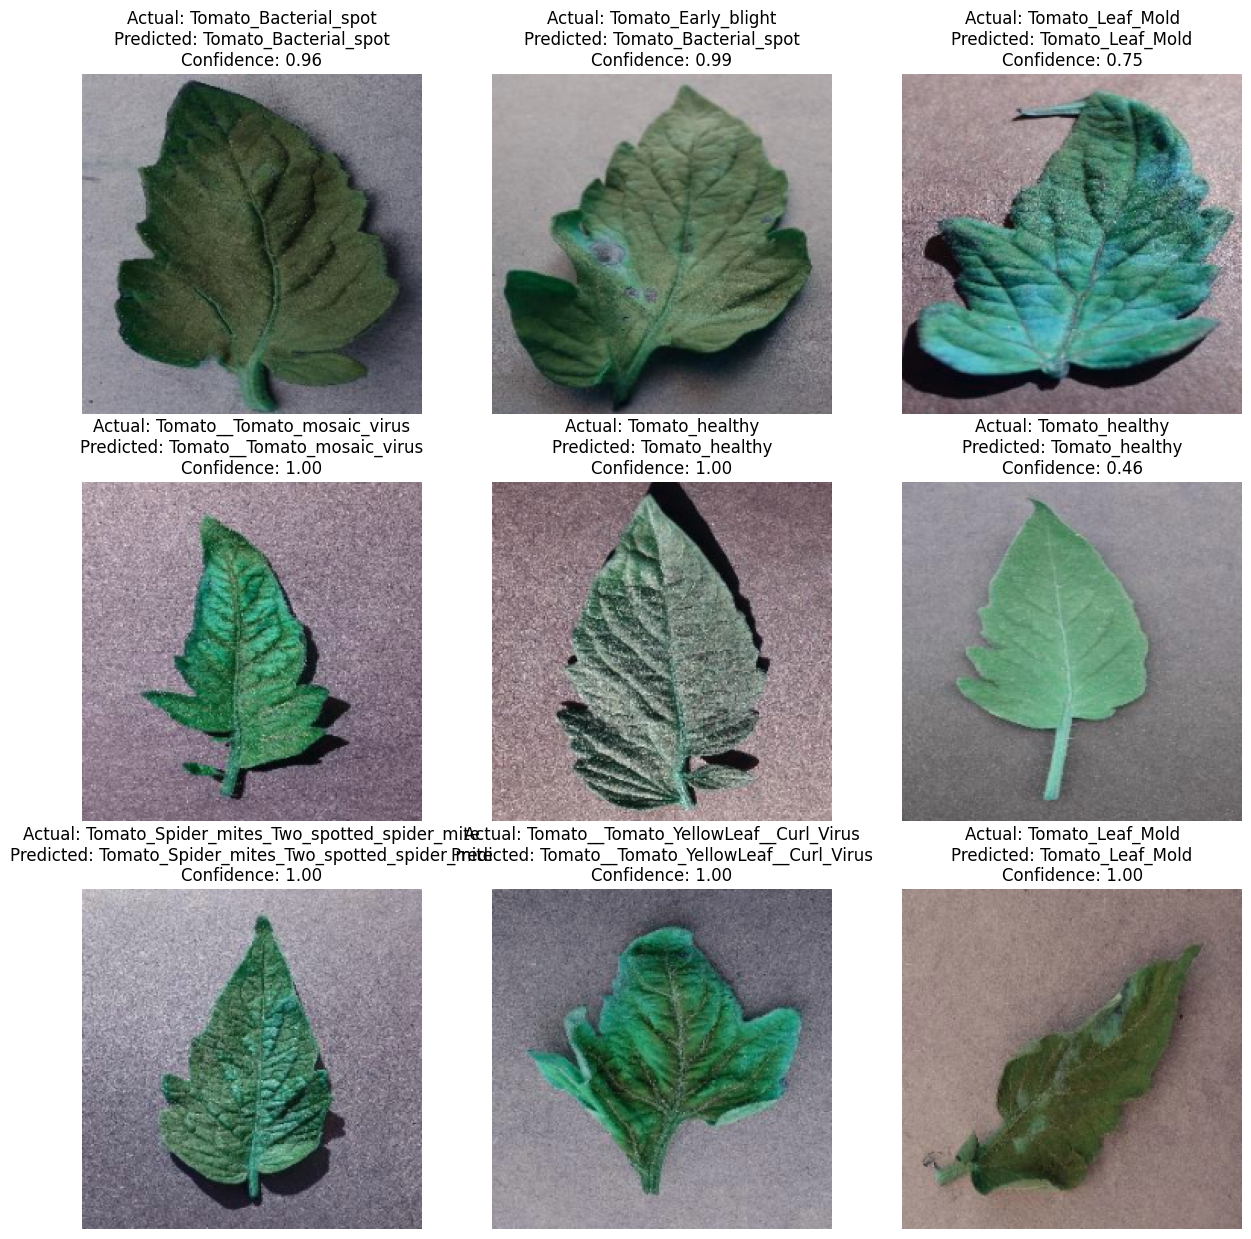

In [31]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D

# Use the existing CLASSES variable, no need to redefine
# CLASSES = list(train_generator.class_indices.keys())  # Remove this line

def predict(model, image):
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    prediction = model.predict(image)
    predicted_class_index = tf.argmax(prediction[0]).numpy()
    confidence = tf.reduce_max(prediction[0]).numpy()
    predicted_class = CLASSES[predicted_class_index] # 'CLASSES' is the global variable
    return predicted_class, confidence


# Use a generator to feed data to the model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(
    x=X_test,
    y=y_test,  # Use one-hot encoded y_test here
    batch_size=9,  # Batch size for testing
    shuffle=False  # Important for consistent order of prediction
)

X_test_batch, y_test_batch = next(test_generator)

plt.figure(figsize=(15, 15))
for index, image in enumerate(X_test_batch):
    if index < 9:
        ax = plt.subplot(3, 3, index + 1)
        plt.imshow(image)
        predicted_class, confidence = predict(inception_model, image)

        # Get the actual class label from the one-hot encoded y_test
        label = tf.argmax(y_test_batch[index]).numpy()
        actual_class = CLASSES[label] # 'CLASSES' is the global variable

        plt.title(f'Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}')
        plt.axis('off')
    else:
        break
plt.show()